# Exam image/video analysis
8264937 Sarah Hsu

#Question 3
Use the subsets of movie trailers from 1920-1940, 1960-1980 and 2000-2020 from exercise 6.1, but instead of comparing the shot types and shot lengths, use one of the (pre-trained) image feature extraction methods we discussed in exercise 5.2 to compare the subsets, and explain your choice.
Make a plan for tackling the dimensionality of the data. How are you going to compare the subsets? Explain the choices you make carefully. Then implement your plan and interpret the results.

###• Explanation of choice for features, plan for tackling the dimensionality (ca. 350 words)

In order to analyze the differences between the three subsets of movie trailers from 1920-1940, 1960-1980 and 2000-2020, I would like to use the method of `color analysis` to discover what is the most `dominant color` and the `median RGB` used in the three periods and whether it will change over time.

First, to tackle with the dimensionality of the data, I randomly select five videos for each subset. Then, I use `Scene detection` and set the threshold = 20 to detect scenes with different contents and filter out the similar images to get the useful data to analyze. However, to make sure we have the balanced data of the three periods, I randomly select 250 images from each subset after scene detection. With the above processes, we can get a list of decisive images without unmeaningful frames that could reduce the runtime.

Secondly, we can start to analyze the color with above processed frames to discover the differences between these videos and periods. I analyze the RGB values of each image to get the name of the color with the highest proportion as the dominant one. Additionally, to get further understanding of the features, I also look into the median of the RGB values in a picture that we can not only know what is the most dominant color but also have an idea about the color range. To work efficiently, I will define a function including above methods then put these results into data frame.

Finally, to get better interpretation of the results, I will visualize the amount of the most dominant colors across the years with a line plot. However, instead of only comparing the dominant color, I think the RGB value can give us more insights into the color trends. In this case, I will apply the box plot to see the quartiles and violin plot to visualize the distributions because if we only look at the mean or count value which might cancel out the extreme value of RGB(e.g. black=(0,0,0), Red=(255,0,0)) whereas it is a quite important representation of a color.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The dataset represents a diverse collection of Hollywood movie trailers accessible
import pandas as pd
df = pd.read_csv('trailers.csv')
df.head()

,trailer_title,url,imdb_id,year,rating,votes,genre
0,THE BIG PARADE trailer,https://archive.org/download/TheBigParadeTrail...,15624,1925,7.9,6148.0,Drama|Romance|War
1,ALL QUIET ON THE WESTERN FRONT 1930 trailer,https://archive.org/download/AllQuietOnTheWest...,20629,1930,8.0,56948.0,Drama|War
2,THE OREGON TRAIL trailer,https://archive.org/download/TheOregonTrailTra...,20691,1926,7.2,3353.0,Adventure|Romance|Western
3,FIVE STAR FINAL trailer,https://archive.org/download/FiveStarFinalTrai...,21873,1931,7.2,1790.0,Crime|Drama
4,LITTLE CAESAR trailer,https://archive.org/download/LittleCaesarTrail...,21079,1931,7.3,11958.0,Action|Crime|Drama|Romance


In [ ]:
# make three subsets of movies published in three different periods: 1920-1940, 1960-1980 and 2000-2020
# then get five random samples of videos for each subset
df1 = df[df.year <= 1940 ].sample(5, random_state=42)
df2 = df[(df.year >= 1960) & (df.year <= 1980)].sample(5, random_state=42)
df3 = df[(df.year >= 2000) & (df.year <= 2020)].sample(5, random_state=42)

## Download the videos

In [ ]:
!pip install wget

import os
import wget
from tqdm.auto import tqdm

# download the trailers with the codes in the manual
def download_videos(subset,
                    output_folder='videos',
                   subset_folder='1920_1940'):
    
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    if not os.path.exists(os.path.join(output_folder, subset_folder)):
        os.mkdir(os.path.join(output_folder, subset_folder))
    
    video_paths = []
    for video in tqdm(subset.itertuples(), total=len(subset)):
        video_url = video.url
        output_path = os.path.join(output_folder, subset_folder, video.trailer_title + '.mp4') # name of files
        if not os.path.exists(output_path):
            filename = wget.download(video_url, out=output_path)
        video_paths.append(output_path)
    return video_paths



  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4831bd3220b55065af0f3e0c7141e27443ca489b9e98724e1e24b02f6c0e8837
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
video_paths_1920_1940 = download_videos(df1, 
                              output_folder='videos',  # video will be in the folder 'videos'
                              subset_folder='1920_1940') # and in the folder 1920-1940


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
video_paths_1960_1980 = download_videos(df2, 
                              output_folder='videos',  # video will be in the folder 'videos'
                              subset_folder='1960_1980') # and in the folder 1960_1980


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
video_paths_2000_2020 = download_videos(df3, 
                              output_folder='videos',  # video will be in the folder 'videos'
                              subset_folder='2000_2020') # and in the folder 2000_2020

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
!pip install scenedetect
!pip install webcolors
!pip install colorgram.py

     |████████████████████████████████| 98 kB 4.5 MB/s 


In [ ]:
# packages
import cv2
from tqdm import tqdm_notebook
import numpy as np
from scenedetect import VideoManager
from scenedetect import SceneManager
from scenedetect.detectors import ContentDetector
from scenedetect.detectors import ContentDetector
import webcolors
import colorgram
import io
import urllib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

## Tackling the dimensionality


In [ ]:

def process_video(filename):

  print(filename)
  cap = cv2.VideoCapture(filename) 
  df = pd.DataFrame()

  # 1) Scene detection
  def find_scenes(video_path, threshold):
      video_manager = VideoManager([video_path])
      scene_manager = SceneManager()
      scene_manager.add_detector(
          ContentDetector(threshold=threshold))
      base_timecode = video_manager.get_base_timecode()
      video_manager.set_downscale_factor()
      video_manager.start()
      scene_manager.detect_scenes(frame_source=video_manager, show_progress=False)    
      return scene_manager.get_scene_list(base_timecode)

  scene_list = find_scenes(filename, threshold=20) # set the threshold to 20
  
  frames = []
  shot_length = []
  for start_time, end_time in scene_list:
      duration = end_time - start_time
      #get the frame that is exactlly in the middle of the scene that represents a specific one
      frame = (start_time.get_frames() + int(duration.get_frames() / 2))
      cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
      ret, frame = cap.read()
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frames.append(frame)
      shot_length.append(duration.get_seconds())


  # 2) dominent color 
  def get_colour_name(rgb_triplet):
      min_colours = {}
      for key, name in webcolors.CSS21_HEX_TO_NAMES.items():
          r_c, g_c, b_c = webcolors.hex_to_rgb(key)
          rd = (r_c - rgb_triplet[0]) ** 2
          gd = (g_c - rgb_triplet[1]) ** 2
          bd = (b_c - rgb_triplet[2]) ** 2
          min_colours[(rd + gd + bd)] = name
      return min_colours[min(min_colours.keys())]

  #!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
  
  dominant_color = []

  median_R = []
  median_G = []
  median_B = []
  for frame in frames:
      img = Image.fromarray(frame.astype(np.uint8))  
      colors = colorgram.extract(img, 1) # only get the one most dominant color
      for color in colors:
        rgb = tuple(color.rgb)
        color_name = get_colour_name(rgb) # get the color name 
        dominant_color.append(color_name) # append to list
        
  # 3) Median RGB
  # put the R,G,B results in separate colunms
      median_r, median_g, median_b = np.median(frame, axis=(0,1))
      median_R.append(median_r)
      median_G.append(median_g)
      median_B.append(median_b)

  # put results in data frame
  df['video'] = [filename for i in range(len(frames))]
  df['shot'] = range(len(frames))   
  df['dominant color'] = dominant_color # add list a column
  df['Red'] = median_R 
  df['Green'] = median_G
  df['Blue'] = median_B

  return df

In [ ]:
# add the filepath in df for the function to run
df1['path'] = df1.trailer_title.apply(lambda x : ('/content/videos/1920_1940/' + x + '.mp4')) #the filepath

# process the trailers from 1920-1940(subset1) with the funciton we define above
process_video1 = []
for movie in df1.path: 
  process_video1.append(process_video(movie))
df_video1 = pd.concat(process_video1) 
df_video1['year'] = '1920-1940'
df_video1.head()

/content/videos/1920_1940/IDIOT'S DELIGHT trailer.mp4
/content/videos/1920_1940/GOLD DIGGERS OF 1933 trailer.mp4
/content/videos/1920_1940/CRADLE WILL ROCK trailer.mp4
/content/videos/1920_1940/ANGELS WITH DIRTY FACES trailer.mp4
/content/videos/1920_1940/YOUNG TOM EDISON trailer.mp4


,video,shot,dominant color,Red,Green,Blue,year
0,/content/videos/1920_1940/IDIOT'S DELIGHT trai...,0,black,0.0,0.0,0.0,1920-1940
1,/content/videos/1920_1940/IDIOT'S DELIGHT trai...,1,gray,116.0,116.0,117.0,1920-1940
2,/content/videos/1920_1940/IDIOT'S DELIGHT trai...,2,gray,93.0,93.0,93.0,1920-1940
3,/content/videos/1920_1940/IDIOT'S DELIGHT trai...,3,black,18.0,18.0,18.0,1920-1940
4,/content/videos/1920_1940/IDIOT'S DELIGHT trai...,4,black,62.0,62.0,62.0,1920-1940


In [ ]:
# add the filepath in df for the function to run
df2['path'] = df2.trailer_title.apply(lambda x : ('/content/videos/1960_1980/' + x + '.mp4')) #the filepath

# process the trailers from 1960-1980(subset 2) with the funciton we define above
process_video2 = []
for movie in df2.path:
  process_video2.append(process_video(movie))
df_video2 = pd.concat(process_video2)
df_video2['year'] = '1960-1980'
df_video2.head()

/content/videos/1960_1980/KHARTOUM trailer.mp4
/content/videos/1960_1980/Z FOR ZACHARIAH trailer.mp4
/content/videos/1960_1980/LADY SNOWBLOOD 2 trailer.mp4
/content/videos/1960_1980/CHILDREN OF THE DAMNED trailer.mp4
/content/videos/1960_1980/THE SCALPHUNTERS trailer.mp4


,video,shot,dominant color,Red,Green,Blue,year
0,/content/videos/1960_1980/KHARTOUM trailer.mp4,0,black,0.0,0.0,0.0,1960-1980
1,/content/videos/1960_1980/KHARTOUM trailer.mp4,1,black,62.0,46.0,33.0,1960-1980
2,/content/videos/1960_1980/KHARTOUM trailer.mp4,2,teal,58.0,88.0,124.0,1960-1980
3,/content/videos/1960_1980/KHARTOUM trailer.mp4,3,black,166.0,54.0,22.0,1960-1980
4,/content/videos/1960_1980/KHARTOUM trailer.mp4,4,black,47.0,35.0,25.0,1960-1980


In [ ]:
# add the filepath in df for the function to run
df3['path'] = df3.trailer_title.apply(lambda x : ('/content/videos/2000_2020/' + x + '.mp4')) #the filepath

# process the trailers from 2000-2020(subset 3) with the funciton we define above
process_video3 = []
for movie in df3.path:
  process_video3.append(process_video(movie))
df_video3 = pd.concat(process_video3)
df_video3['year'] = '2000-2020' 
df_video3.head()

/content/videos/2000_2020/NORBIT trailer.mp4
/content/videos/2000_2020/EEGAH trailer.mp4
/content/videos/2000_2020/FLIGHTPLAN trailer.mp4
/content/videos/2000_2020/HANGMAN'S CURSE trailer.mp4
/content/videos/2000_2020/THE DYING GAUL trailer.mp4


,video,shot,dominant color,Red,Green,Blue,year
0,/content/videos/2000_2020/NORBIT trailer.mp4,0,green,0.0,86.0,25.0,2000-2020
1,/content/videos/2000_2020/NORBIT trailer.mp4,1,black,0.0,0.0,0.0,2000-2020
2,/content/videos/2000_2020/NORBIT trailer.mp4,2,black,6.0,41.0,78.0,2000-2020
3,/content/videos/2000_2020/NORBIT trailer.mp4,3,black,0.0,3.0,3.0,2000-2020
4,/content/videos/2000_2020/NORBIT trailer.mp4,4,black,0.0,2.0,1.0,2000-2020


In [ ]:
# select a same amount of samples ramdomly to balance the data
df_video1 = df_video1.sample(n=250,replace=True)
df_video2 = df_video2.sample(n=250,replace=True)
df_video3 = df_video3.sample(n=250,replace=True)

## Visualization
###Most dominant color


In [ ]:
# Count the numbers of the dominant colors in each subset
color1 = df_video1['dominant color'].value_counts()
color2 = df_video2['dominant color'].value_counts()
color3 = df_video3['dominant color'].value_counts()
# combine results to a dataframe
color = pd.DataFrame({'1920-1940': color1,'1960-1980':color2, '2000-2020':color3}).fillna(0)
color

,1920-1940,1960-1980,2000-2020
black,228.0,233.0,215.0
gray,21.0,10.0,12.0
green,0.0,0.0,3.0
maroon,0.0,0.0,4.0
silver,0.0,1.0,12.0
teal,0.0,5.0,0.0
white,1.0,1.0,4.0


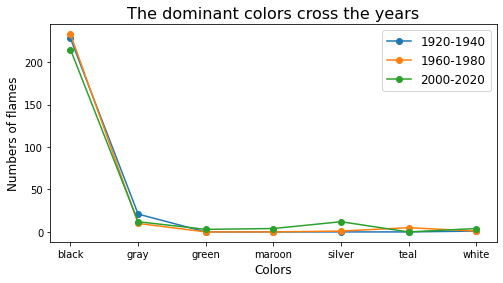

In [ ]:
import matplotlib.pyplot as plt

# plot a lineplot to depict the trends
plt.figure(figsize=(8,4))
plt.plot(color, marker='o')

# set the title and label
plt.title('The dominant colors cross the years', fontsize=16)
plt.xlabel("Colors",fontsize=12)
plt.ylabel("Numbers of flames",fontsize=12)
plt.legend(['1920-1940','1960-1980','2000-2020'],fontsize=12)
plt.show()

## Median RGB

Text(0.5, 1.0, '2000-2020')

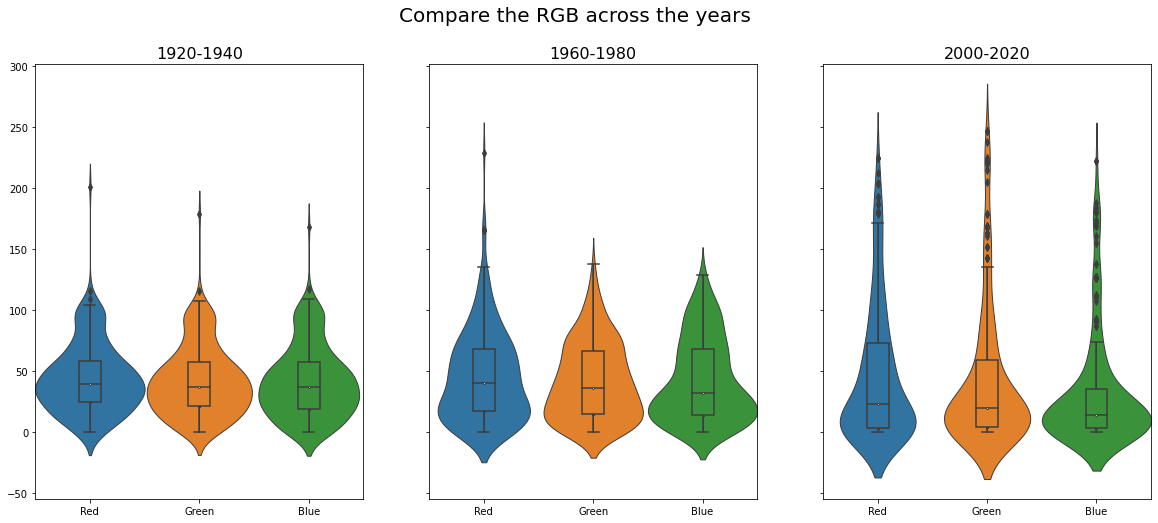

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

# set the figure with three subplots
# share the same scale of y(color value) to compare the differences between three subsets clearly 
fig, axes = plt.subplots(1, 3, figsize=(20, 8), facecolor='white', sharey=True)

# plot the violin plot & box plot for each subset to depict the distributions
rgb1 = df_video1.iloc[:, 3:6] # select the columns of R, G, and B of subset 1
sb.violinplot(ax=axes[0], data = rgb1,  linewidth=1, width=1)
sb.boxplot(ax=axes[0], data= rgb1, width=0.2, boxprops={'zorder': 2}, color=None)

rgb2 = df_video2.iloc[:, 3:6] # select the columns of R, G, and B of subset 2
sb.violinplot(ax=axes[1],data = rgb2,  linewidth=1, width=1)
sb.boxplot(ax=axes[1], data= rgb2, width=0.2, boxprops={'zorder': 2}, color=None)

rgb3 = df_video3.iloc[:, 3:6] # select the columns of R, G, and B of subset 2
sb.violinplot(ax=axes[2], data = rgb3,  linewidth=1, width=1)
sb.boxplot(ax=axes[2], data= rgb3, width=0.2, boxprops={'zorder': 2}, color=None)

# add a title to the figure and each subplot 
fig.suptitle("Compare the RGB across the years", fontsize = 20)
axes[0].set_title("1920-1940", fontsize = 16)
axes[1].set_title("1960-1980", fontsize = 16)
axes[2].set_title("2000-2020", fontsize = 16)


###• Interpretation and conclusion (ca. 200 words)

With color analysis of five videos of each subset, we can assume that the most dominant colors are still based on black, but the trailers become more colorful across the years. 

In the line plot of the dominant colors, we can't find notable differences between these three subsets, but we can know the videos from 2000-2020 contain more different colors. Moreover, the violin plots and box plots demonstrate the RGB distributions of the images in each subset that we can discover further relationships. In both violin plots and box plots, we can find in the more recent years, the trailers introduce more diversity of the colors because their distributions of color range more spread out between 0 and 255. For example, the trailers published in 2000-2020 depict a larger range of quartiles in RGB than trailers in other periods. By contrast, the trailers in 1920-1940, there is a high density in the RGB range from 25 to 60 that also indicates the simple compositions of color. 

In conclusion, most of the videos are still based on black color over the years. Nevertheless, there is a trend that producers try to use more colorful features from 1920 to 2020. In my opinion, that also relevant to our technique's development and human interests that we are not limited to black-white display nowadays and people might be more attracted by diverse compositions.  